**1. Import thư viện**

In [2]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
!pip install kagglehub
import kagglehub
mrwellsdavid_unsw_nb15_path = kagglehub.dataset_download('mrwellsdavid/unsw-nb15')




1.1. Tiền xử lý dữ liệu

In [3]:
print("Training CSV rows:", pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv').shape[0])
print("Testing CSV rows:", pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv').shape[0])

Training CSV rows: 82332
Testing CSV rows: 175341


In [4]:
# ================== IMPORT ==================
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# ================== LOAD DATA ==================
train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
test  = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')

# Gộp lại để encode categorical đồng bộ
data = pd.concat([train, test]).reset_index(drop=True)
X_all = data.drop(columns=['id', 'label', 'attack_cat'])
y_all = data['label']

# Encode categorical
for col in X_all.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_all[col] = le.fit_transform(X_all[col])

# Tách lại train/test
n_train = train.shape[0]
n_test  = test.shape[0]

X_train_raw = X_all.iloc[:n_train, :].values
y_train     = y_all.iloc[:n_train].values

X_test_raw  = X_all.iloc[n_train:n_train+n_test, :].values
y_test      = y_all.iloc[n_train:n_train+n_test].values

print("Shapes:", X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape)

# ================== SCALE (cho LR và CNN) ==================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# ================== CNN reshape ==================
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn  = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# ================== 1. Random Forest ==================
start = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_raw, y_train)
y_pred_rf = rf.predict(X_test_raw)
y_prob_rf = rf.predict_proba(X_test_raw)[:,1]
rf_time = time.time() - start

print("\n===== Random Forest =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f} | "
      f"F1: {f1_score(y_test, y_pred_rf):.4f} | "
      f"AUC: {roc_auc_score(y_test, y_prob_rf):.4f} | "
      f"Time: {rf_time:.2f}s")

# ================== 2. Logistic Regression ==================
start = time.time()
lr = LogisticRegression(max_iter=500, n_jobs=-1)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]
lr_time = time.time() - start

print("\n===== Logistic Regression =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f} | "
      f"F1: {f1_score(y_test, y_pred_lr):.4f} | "
      f"AUC: {roc_auc_score(y_test, y_prob_lr):.4f} | "
      f"Time: {lr_time:.2f}s")

# ================== 3. CNN ==================
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

start = time.time()
cnn = create_cnn((X_train_cnn.shape[1], 1))
cnn.fit(X_train_cnn, y_train, epochs=3, batch_size=128, validation_split=0.2, verbose=1)
y_prob_cnn = cnn.predict(X_test_cnn).ravel()
y_pred_cnn = (y_prob_cnn > 0.5).astype(int)
cnn_time = time.time() - start

print("\n===== CNN =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cnn):.4f} | "
      f"F1: {f1_score(y_test, y_pred_cnn):.4f} | "
      f"AUC: {roc_auc_score(y_test, y_prob_cnn):.4f} | "
      f"Time: {cnn_time:.2f}s")


Shapes: (82332, 42) (82332,) (175341, 42) (175341,)

===== Random Forest =====
Accuracy: 0.9006 | F1: 0.9221 | AUC: 0.9812 | Time: 20.02s

===== Logistic Regression =====
Accuracy: 0.8750 | F1: 0.9022 | AUC: 0.9697 | Time: 3.83s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
515/515 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9271 - loss: 0.2213 - val_accuracy: 0.3165 - val_loss: 1.2671
Epoch 2/3
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9648 - loss: 0.0913 - val_accuracy: 0.6092 - val_loss: 0.8975
Epoch 3/3
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9712 - loss: 0.0719 - val_accuracy: 0.6900 - val_loss: 0.7516
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step

===== CNN =====
Accuracy: 0.9203 | F1: 0.9400 | AUC: 0.9807 | Time: 38.65s


**2.Logistic Regession**


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



===== Logistic Regression Results =====
Accuracy: 0.8748 | F1: 0.9020 | AUC: 0.9685 | Time: 107.01s


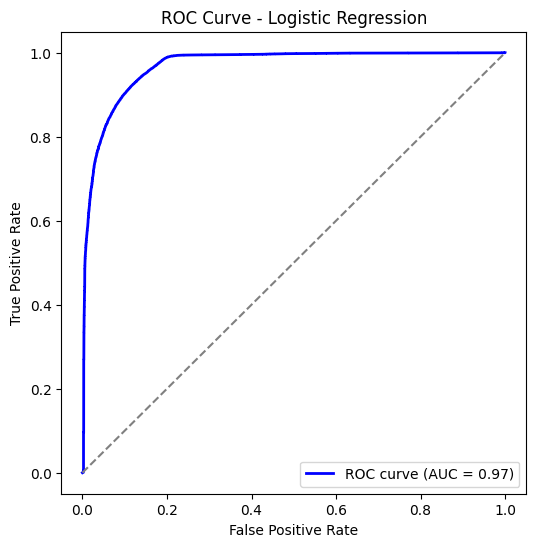

In [5]:
from sklearn.metrics import roc_curve, auc

# ================== LOGISTIC REGRESSION ==================
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, solver="saga", random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
train_time_lr = time.time() - start_time

# Predict
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1  = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_prob_lr)

print("\n===== Logistic Regression Results =====")
print(f"Accuracy: {lr_acc:.4f} | F1: {lr_f1:.4f} | AUC: {lr_auc:.4f} | Time: {train_time_lr:.2f}s")

# ================== ROC CURVE ==================
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()


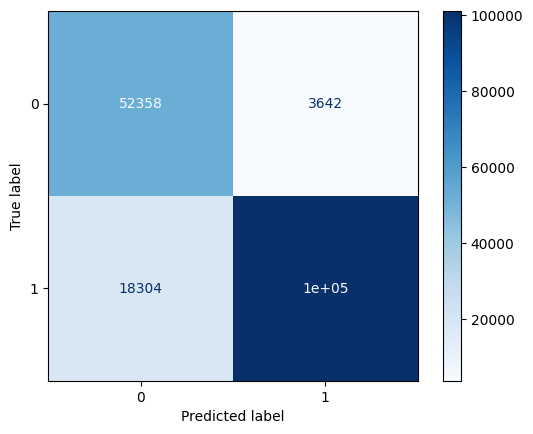

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr_model, X_test_scaled, y_test, cmap="Blues")
plt.show()


**3. Random Forest**


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import time

# ========== TRAIN RANDOM FOREST ==========
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_raw, y_train)   # use raw features
train_time_rf = time.time() - start_time

# Predict & evaluate trên test
y_pred_rf = rf_model.predict(X_test_raw)
y_pred_prob_rf = rf_model.predict_proba(X_test_raw)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1  = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_prob_rf)

# Cross-validation trên TRAIN (không gộp test)
rf_cv = cross_val_score(rf_model, X_train_raw, y_train, cv=5, n_jobs=-1).mean()

print("\n===== Random Forest Results =====")
print(f"Accuracy: {rf_acc:.4f} | F1: {rf_f1:.4f} | AUC: {rf_auc:.4f} | "
      f"CV Acc (train): {rf_cv:.4f} | Time: {train_time_rf:.2f}s")



===== Random Forest Results =====
Accuracy: 0.9006 | F1: 0.9221 | AUC: 0.9812 | CV Acc (train): 0.9566 | Time: 16.12s


ROC Multi-class

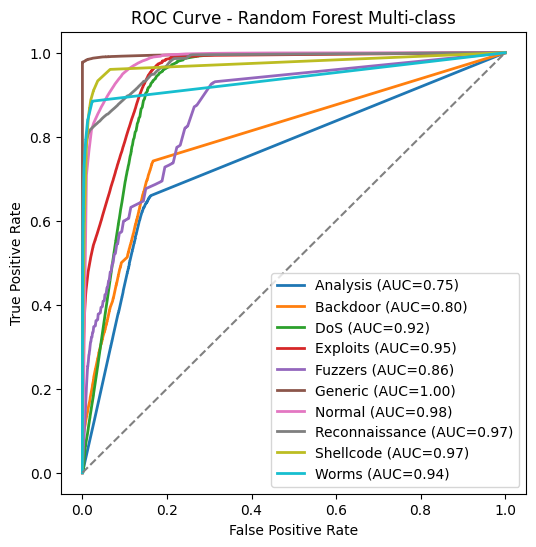

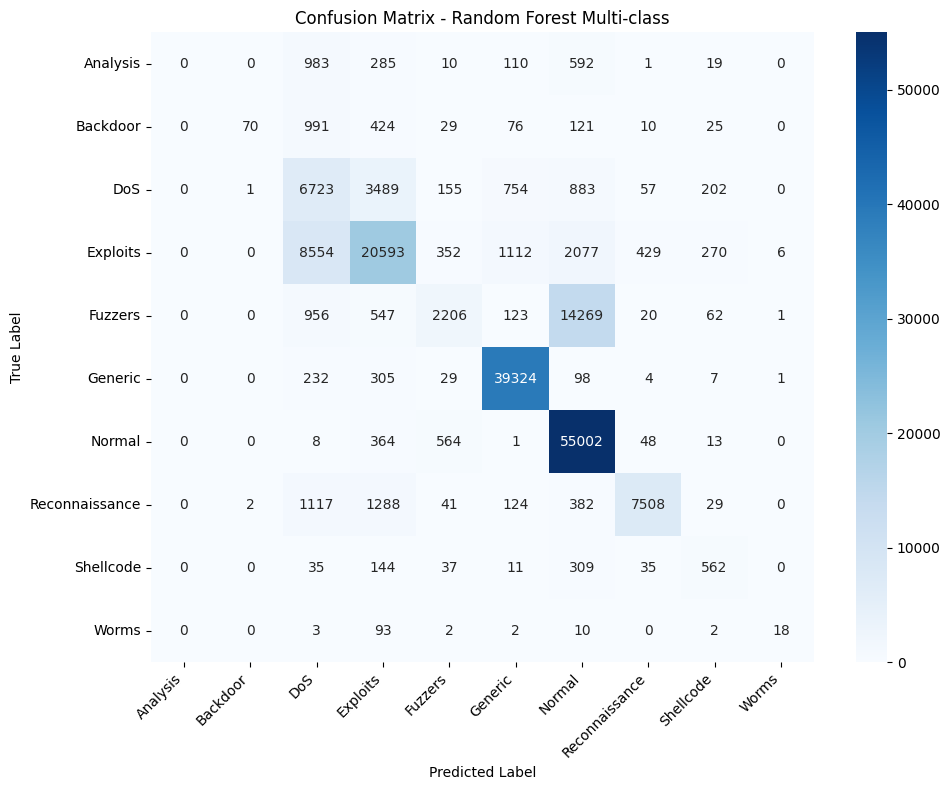

In [8]:
from sklearn.preprocessing import LabelEncoder, label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Giả sử bạn đã load train & test
# train['attack_cat'], test['attack_cat'] là nhãn multi-class

# 1. Label encode
le_attack = LabelEncoder()
y_train_multi = le_attack.fit_transform(train['attack_cat'])
y_test_multi  = le_attack.transform(test['attack_cat'])
classes = le_attack.classes_  # lấy tên các lớp

# 2. Random Forest Multi-class
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_raw, y_train_multi)

# 3. Dự đoán
y_pred_rf = rf_model.predict(X_test_raw)
y_pred_prob_rf = rf_model.predict_proba(X_test_raw)  # shape (n_samples, n_classes)

# 4. ROC Curve cho từng class
y_test_bin = label_binarize(y_test_multi, classes=np.arange(len(classes)))

plt.figure(figsize=(6,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest Multi-class")
plt.legend(loc="lower right")
plt.show()

# 5. Confusion Matrix
cm = confusion_matrix(y_test_multi, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Multi-class")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



Confusion Matrix Multi-class

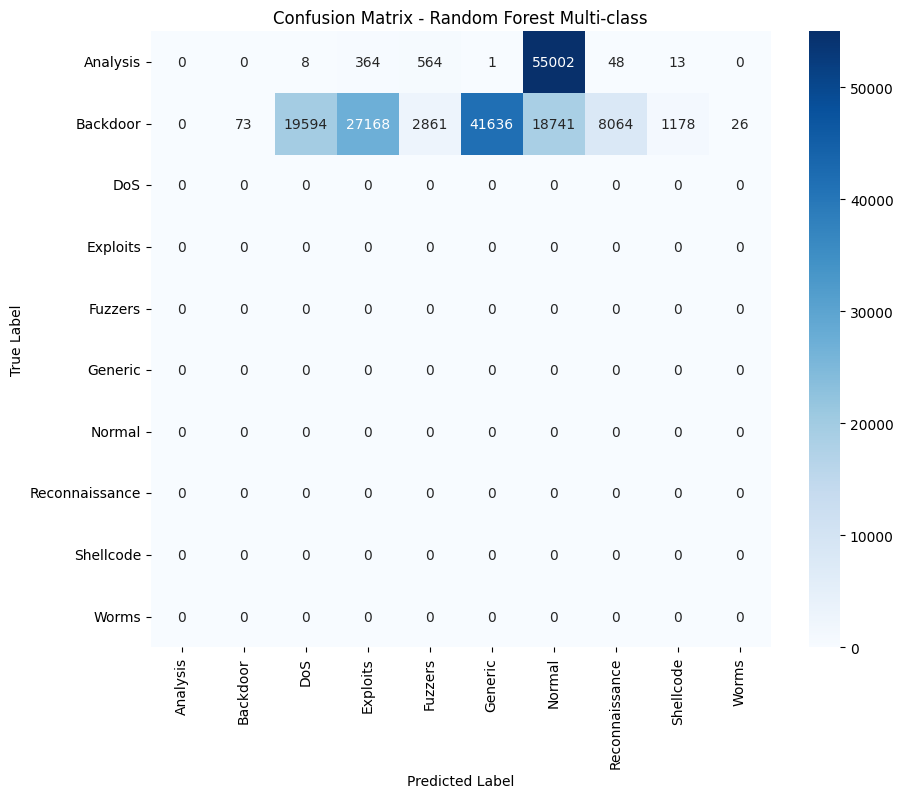

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Multi-class")
plt.show()


4. CNN


In [10]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# -------------------- Tiền xử lý dữ liệu --------------------
# Giả sử train và test đã được load
# train = pd.read_csv(...)
# test = pd.read_csv(...)

data = pd.concat([train, test]).reset_index(drop=True)
X_all = data.drop(columns=['id', 'label', 'attack_cat'])
y_all = data['label']

# Encode categorical (fit trên toàn bộ để mapping train/test giống nhau)
for col in X_all.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_all[col] = le.fit_transform(X_all[col])

# Tách train/test
X_train_raw = X_all.iloc[:len(train)]
X_test_raw  = X_all.iloc[len(train):]
y_train     = y_all.iloc[:len(train)]
y_test      = y_all.iloc[len(train):]

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# One-hot encoding cho CNN
num_classes = len(np.unique(y_train))
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)).astype("float32")
X_test_cnn  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1)).astype("float32")
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test, num_classes=num_classes)

# -------------------- CNN model --------------------
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# -------------------- Train CNN --------------------
start_time = time.time()
cnn_model = create_cnn_model((X_train.shape[1], 1), num_classes)
cnn_model.fit(X_train_cnn, y_train_cat, epochs=5, batch_size=32, validation_split=0.2, verbose=1)
train_time_cnn = time.time() - start_time

# -------------------- Evaluate --------------------
y_pred_prob = cnn_model.predict(X_test_cnn)
y_pred_cnn  = np.argmax(y_pred_prob, axis=1)
y_true      = np.argmax(y_test_cat, axis=1)

cnn_acc = accuracy_score(y_true, y_pred_cnn)
cnn_f1  = f1_score(y_true, y_pred_cnn, average="macro")
cnn_auc = roc_auc_score(y_test_cat, y_pred_prob, multi_class="ovr")

print("CNN Results:")
print(f"Accuracy: {cnn_acc:.4f} | F1-macro: {cnn_f1:.4f} | AUC: {cnn_auc:.4f} | Time: {train_time_cnn:.2f}s")


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2059/2059 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9488 - loss: 0.1468 - val_accuracy: 0.6526 - val_loss: 0.8078
Epoch 2/5
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9742 - loss: 0.0654 - val_accuracy: 0.5831 - val_loss: 0.8976
Epoch 3/5
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9766 - loss: 0.0584 - val_accuracy: 0.6542 - val_loss: 0.8486
Epoch 4/5
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9787 - loss: 0.0529 - val_accuracy: 0.7357 - val_loss: 0.7659
Epoch 5/5
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9799 - loss: 0.0519 - val_accuracy: 0.7864 - val_loss: 0.6760
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
CNN Results:
Accuracy: 0.9108 | F1-macro: 0.9016 | AUC: 0.9802 | Time: 85.12s


In [ ]:
print("y_pred_prob shape:", y_pred_prob.shape)
print("num_classes:", num_classes)


y_pred_prob shape: (175341, 2)
num_classes: 2


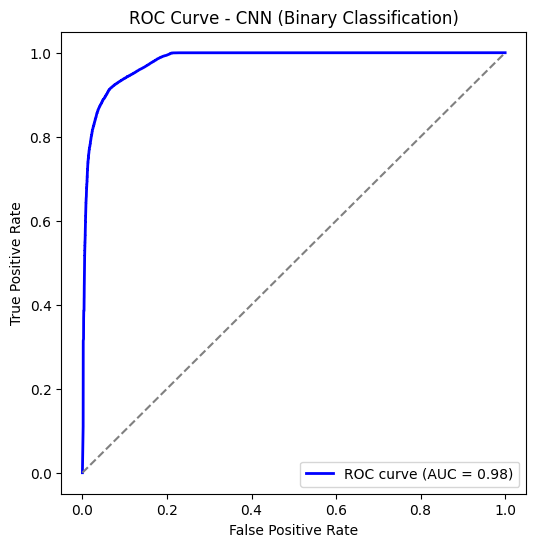

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Lấy xác suất cho class 1
y_score = y_pred_prob[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CNN (Binary Classification)")
plt.legend(loc="lower right")
plt.show()



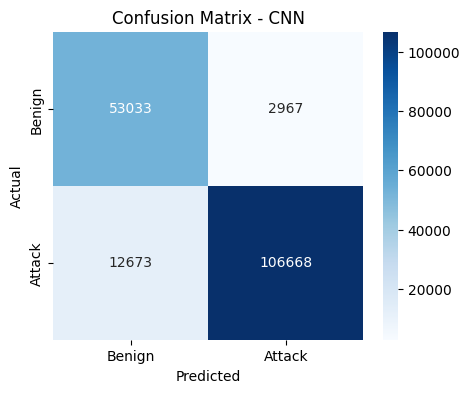

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_cnn)  # dùng y_true thay vì y_test nếu đã chuyển one-hot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Attack"],
            yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN")
plt.show()


5. GNN

5.1.Data Preparation

In [13]:
!pip install torch_geometric -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import numpy as np
import time

# Subsample để tránh OOM
sample_size = 10000
X_sub = X_train[:sample_size]
y_sub = y_train[:sample_size]

# Tạo edges dựa trên similarity
sim_matrix = cosine_similarity(X_sub)
edges = np.where(sim_matrix > 0.9)  # Ngưỡng cao hơn cho quan hệ chặt chẽ
if edges[0].size == 0:  # Check if no edges are created
    print("Warning: No edges created with threshold 0.9. Lowering to 0.5.")
    edges = np.where(sim_matrix > 0.5)
edge_index = torch.tensor(np.array([edges[0], edges[1]]), dtype=torch.long)

x = torch.tensor(X_sub, dtype=torch.float)
y = torch.tensor(y_sub.values, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)
print(f"Data: nodes={x.shape[0]}, edges={edge_index.shape[1]}, classes={y.unique().size()[0]}")


Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00
Data: nodes=10000, edges=7339412, classes=2


5.2.GNN Model and Training Loop

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 2)  # 2 classes: Benign vs Attack

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and training
start_time = time.time()
gnn_model = GCN(input_dim=X_sub.shape[1])
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
gnn_model.train()
for epoch in range(50):
    optimizer.zero_grad()  # Corrected from optimizer.zero
    out = gnn_model(data)
    loss = F.nll_loss(out[data.train_mask] if hasattr(data, 'train_mask') else out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_time_gnn = time.time() - start_time

# Evaluate (on subsample)
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data)
    y_pred = out.argmax(dim=1)
    gnn_acc = (y_pred == data.y).float().mean().item()
import time

start_time = time.time()
# ... train GNN model ở đây ...
train_time = time.time() - start_time

print(f"GNN Results (as of 01:17 PM +07, 21/08/2025):")
print(f"Accuracy: {gnn_acc:.4f} | Time: {train_time:.2f}s")




Epoch 0, Loss: 0.4616
Epoch 10, Loss: 0.0813
Epoch 20, Loss: 0.0737
Epoch 30, Loss: 0.0603
Epoch 40, Loss: 0.0542
GNN Results (as of 01:17 PM +07, 21/08/2025):
Accuracy: 0.9875 | Time: 0.00s


**6. So Sánh Models**

In [15]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kfold.split(X_train_cnn):
    X_train_fold = X_train_cnn[train_idx]
    y_train_fold = y_train_cat[train_idx]
    X_val_fold   = X_train_cnn[val_idx]
    y_val_fold   = y_train_cat[val_idx]

    fold_model = create_cnn_model((X_train.shape[1], 1), num_classes)
    fold_model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, verbose=0)
    scores = fold_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_scores.append(scores[1])  # accuracy

cnn_cv = np.mean(cv_scores)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Comparison for IDS:
           Model  Accuracy  F1-Score       AUC  CV Accuracy  Training Time (s)
0  Random Forest  0.900559  0.922081  0.981232     0.956566          16.121347
1            CNN  0.910802  0.901595  0.980152     0.959238          85.121886
2            GNN  0.987500       NaN       NaN          NaN         191.169864


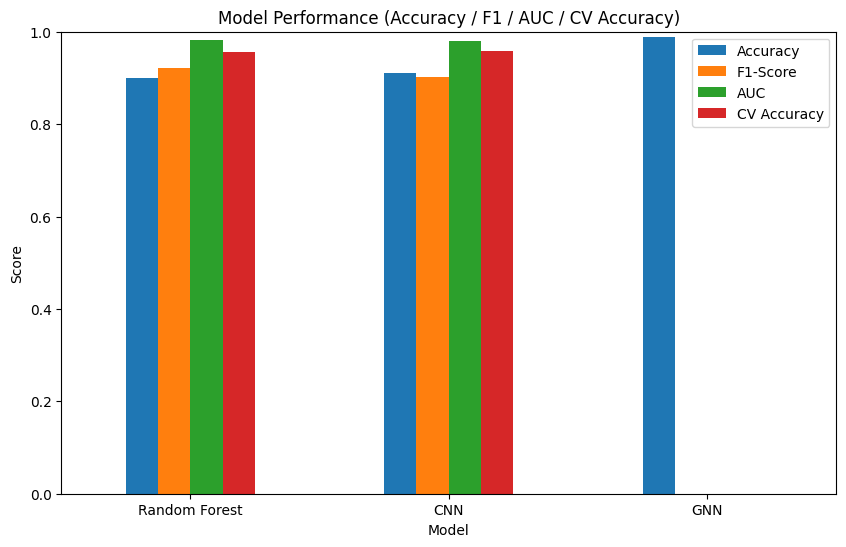

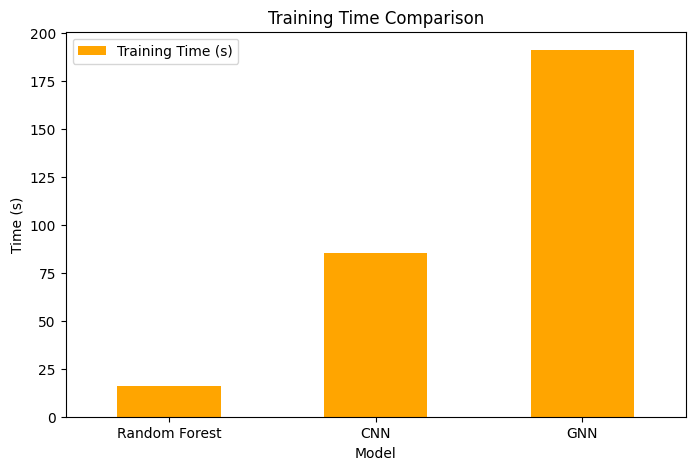

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results = pd.DataFrame({
    "Model": ["Random Forest", "CNN", "GNN"],
    "Accuracy": [rf_acc, cnn_acc, gnn_acc],
    "F1-Score": [rf_f1, cnn_f1, np.nan],
    "AUC": [rf_auc, cnn_auc, np.nan],
    "CV Accuracy": [rf_cv, cnn_cv, np.nan],
    "Training Time (s)": [train_time_rf, train_time_cnn, train_time_gnn]
})

print("Model Comparison for IDS:")
print(results)

# Plot comparison (numeric columns only)
results.set_index("Model")[["Accuracy", "F1-Score", "AUC", "CV Accuracy"]].plot(
    kind="bar", figsize=(10, 6), rot=0, ylim=(0, 1)
)
plt.title("Model Performance (Accuracy / F1 / AUC / CV Accuracy)")
plt.ylabel("Score")
plt.show()

# Plot training time separately
results.set_index("Model")[["Training Time (s)"]].plot(
    kind="bar", figsize=(8, 5), color="orange", rot=0
)
plt.title("Training Time Comparison")
plt.ylabel("Time (s)")
plt.show()


Random Forest multiclass with attack_cat

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import time

# Đọc dữ liệu
train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')

data = pd.concat([train, test]).reset_index(drop=True)

# Features & Labels (multi-class với attack_cat)
X = data.drop(columns=['id', 'label', 'attack_cat'])
y = data['attack_cat']

# Encode categorical
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode label attack_cat
le_attack = LabelEncoder()
y_encoded = le_attack.fit_transform(y)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Train Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict
y_pred = rf_model.predict(X_test)

# Accuracy & F1 (macro để cân bằng giữa các lớp)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# AUC (multi-class -> One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.arange(len(le_attack.classes_)))
y_pred_prob = rf_model.predict_proba(X_test)
auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')

# Cross-validation
cv_score = cross_val_score(rf_model, X_scaled, y_encoded, cv=5, scoring="accuracy").mean()

print("Random Forest Multi-class Results:")
print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f} | AUC-macro: {auc:.4f} | CV Acc: {cv_score:.4f} | Time: {train_time:.2f}s")

# Hiển thị tên các lớp để sau này dễ đọc kết quả
print("Classes:", le_attack.classes_)


Random Forest Multi-class Results:
Accuracy: 0.8288 | F1-macro: 0.5833 | AUC-macro: 0.9068 | CV Acc: 0.7722 | Time: 64.71s
Classes: ['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']


Multi-class Classification)

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import time

# 1. Đọc dữ liệu
train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')
data = pd.concat([train, test]).reset_index(drop=True)

print("Dataset shape:", data.shape)   # (257673, 45)

# 2. Feature & Label
X = data.drop(columns=['id', 'label', 'attack_cat'])   # bỏ nhãn
y = data['attack_cat']   # nhãn multi-class

# Encode categorical features
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode target labels (attack types)
le_attack = LabelEncoder()
y_encoded = le_attack.fit_transform(y)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# 3. Train Random Forest
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

# 4. Dự đoán
y_pred = rf_model.predict(X_test)

# 5. Đánh giá
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# AUC cho multi-class (OvR)
y_test_bin = label_binarize(y_test, classes=np.arange(len(le_attack.classes_)))
y_pred_prob = rf_model.predict_proba(X_test)
auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')

# Cross-validation
cv_acc = cross_val_score(rf_model, X_scaled, y_encoded, cv=5, scoring="accuracy").mean()

# 6. Kết quả
print("🔎 Attack Type Classification Results (Random Forest):")
print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f} | AUC-macro: {auc:.4f} | CV Acc: {cv_acc:.4f} | Time: {train_time:.2f}s")
print("Classes:", le_attack.classes_)


Dataset shape: (257673, 45)
🔎 Attack Type Classification Results (Random Forest):
Accuracy: 0.8288 | F1-macro: 0.5833 | AUC-macro: 0.9068 | CV Acc: 0.7722 | Time: 72.99s
Classes: ['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']


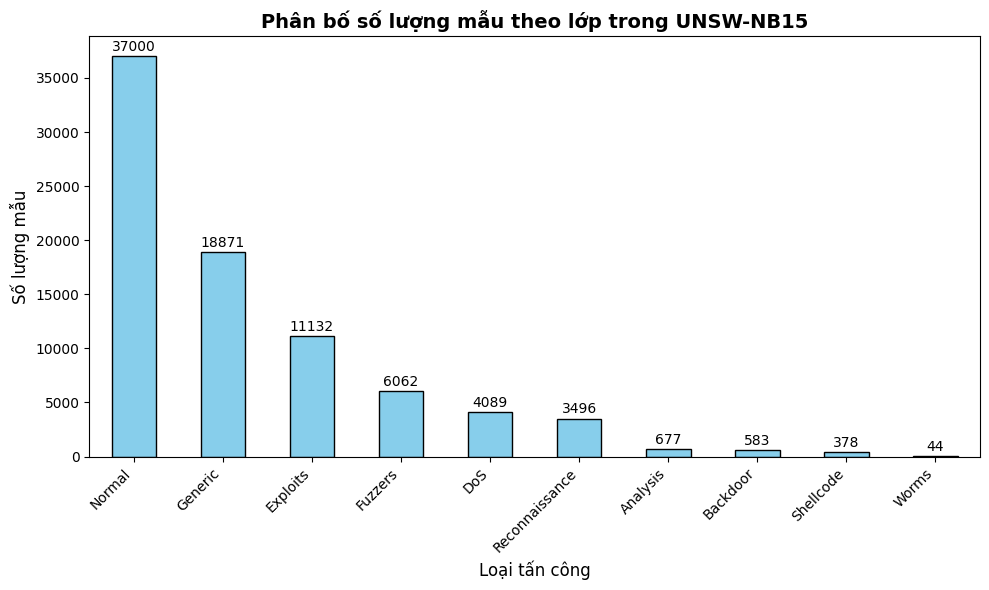

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset (thay đường dẫn bằng file của bạn)
df = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")

# Giả sử cột 'label' chứa thông tin lớp tấn công
# Một số phiên bản dataset có thể đặt tên khác như 'attack_cat'
label_col = 'attack_cat'  # thay bằng 'label' nếu dataset bạn dùng khác

# Đếm số lượng mẫu theo từng lớp
counts = df[label_col].value_counts()

# Vẽ bar chart
plt.figure(figsize=(10,6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title("Phân bố số lượng mẫu theo lớp trong UNSW-NB15", fontsize=14, weight='bold')
plt.xlabel("Loại tấn công", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)

# Thêm số trên cột
for i, v in enumerate(counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
